## Variant Calling Report v1.2.2
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id',
          'h5_concordance_file', 'h5_model_file'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
imgdir = 'plots'

sources = {'Default':(prm['h5_concordance_file'],"concordance"),
           'Trained':(prm['h5_model_file'],"scored_concordance")
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d


prm['mean_var_depth']='{:.2f}'.format(data['Default']['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources['Default'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,170201_BC39
h5_concordance_file,var_compare/170201-BC39_v3.0.3.comp.h5
h5_model_file,var_compare/170201-BC39_v3.0.3.model.h5
mean_var_depth,39.03
truth_sample_name,NA


In [2]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [3]:
def calcPerformance(data, gt=False):
    classify='classify_gt' if gt else 'classify'
    
    d=data.copy()
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score']].sort_values(by=['tree_score'])
    d['label'] = np.where(d[classify]=='fp',0,1)

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    maxF1=max(d[d['mask']]['f1'])
    d['opt']=(d['f1']==maxF1)

    return (d[['recall','precision']][d['mask']],
            d[['recall','precision','f1']][d['opt'] & d['mask']],
            numPos,numNeg)



In [4]:
def plotPerformance(perfCurve,optRes,categories,ext=None,img=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(sources):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.recall,opt.precision,'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.recall[0],
                              'precision':np.nan if perf.empty else opt.precision[0],
                              'F1':np.nan if perf.empty else opt.f1[0]
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve


## Performance: all Data

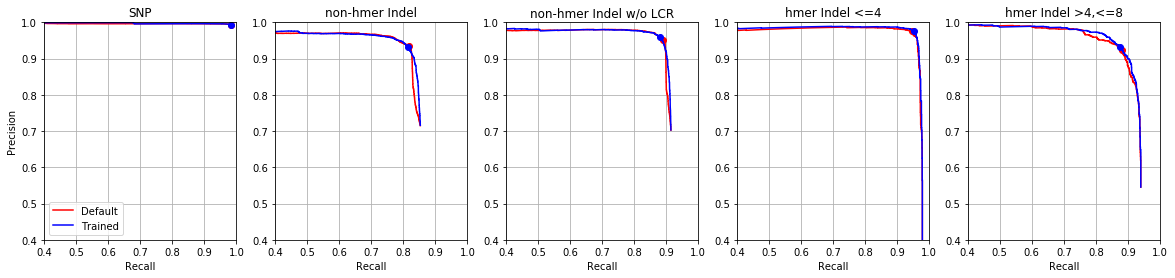

In [5]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary')

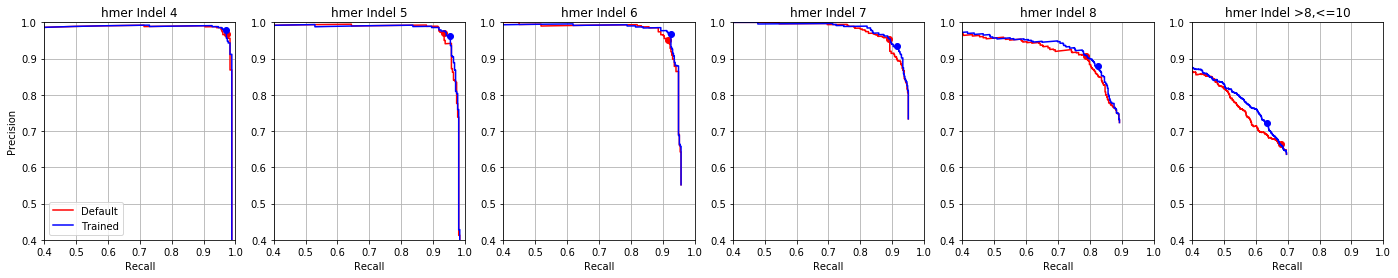

In [6]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers')

In [7]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")
df

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     129910   1639     98.47% 98.27%    99.30% 98.78%   
non-hmer Indel            8247   2805     85.32% 81.93%    93.41% 87.29%   
non-hmer Indel w/o LCR    5856   2270     91.46% 89.07%    95.22% 92.04%   
hmer Indel <=4            2068  20857     98.02% 94.49%    97.65% 96.04%   
hmer Indel >4,<=8         1679   1316     93.98% 88.09%    92.50% 90.24%   
hmer Indel 4               356   1306     98.88% 97.47%    96.66% 97.06%   
hmer Indel 5               306    678     98.37% 93.46%    96.95% 95.17%   
hmer Indel 6               378    295     95.77% 91.80%    95.07% 93.41%   
hmer Indel 7               464    161     95.04% 89.01%    95.38% 92.08%   
hmer Indel 8               531    182     89.27% 78.91%    90.69% 84.39%   
hmer Indel >8,<=10        1387    554     69.65% 67.84%    66.41% 67.12%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     129910   1609     98.47% 98.26%    99.29% 98.77%  
non-hmer Indel            8247   2791     85.32% 81.58%    93.16% 86.99%  
non-hmer Indel w/o LCR    5856   2261     91.46% 88.10%    96.09% 91.92%  
hmer Indel <=4            2068  20857     98.02% 95.16%    97.67% 96.40%  
hmer Indel >4,<=8         1679   1316     93.98% 87.61%    93.28% 90.36%  
hmer Indel 4               356   1306     98.88% 96.91%    98.01% 97.46%  
hmer Indel 5               306    678     98.37% 95.42%    96.37% 95.89%  
hmer Indel 6               378    295     95.77% 92.59%    96.69% 94.59%  
hmer Indel 7               464    161     95.04% 91.59%    93.41% 92.49%  
hmer Indel 8               531    182     89.27% 82.49%    87.95% 85.13%  
hmer Indel >8,<=10        1387    554     69.65% 63.52%    72.33% 67.64%

### Including genotype

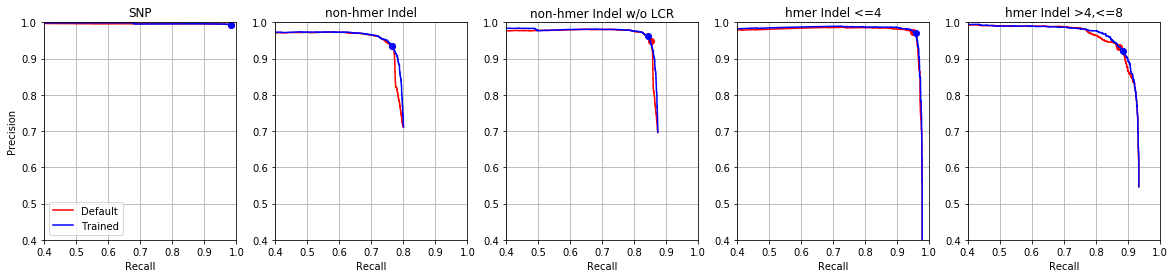

In [8]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(data,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [9]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_gt")
df

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     129796   1753     98.40% 98.21%    99.22% 98.71%   
non-hmer Indel            8335   2717     80.07% 76.62%    93.55% 84.24%   
non-hmer Indel w/o LCR    5880   2246     87.38% 85.34%    94.88% 89.86%   
hmer Indel <=4            2067  20858     97.97% 95.02%    97.23% 96.11%   
hmer Indel >4,<=8         1687   1308     93.36% 87.14%    93.33% 90.13%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     129792   1727     98.40% 98.20%    99.21% 98.70%  
non-hmer Indel            8333   2705     80.08% 76.54%    93.51% 84.18%  
non-hmer Indel w/o LCR    5880   2237     87.38% 84.25%    96.29% 89.87%  
hmer Indel <=4            2067  20858     97.97% 95.74%    96.96% 96.35%  
hmer Indel >4,<=8         1687   1308     93.36% 88.50%    92.22% 90.32%

### homozygous genotyping accuracy

In [33]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df

Default                                           \
                         # pos # neg max recall recall precision     F1   
SNP                      55682     0     99.84% 99.84%   100.00% 99.92%   
non-hmer Indel            2870     0     84.32% 84.32%   100.00% 91.49%   
non-hmer Indel w/o LCR    2282     0     89.35% 89.35%   100.00% 94.38%   
hmer Indel <=4             862     0     99.77% 99.77%   100.00% 99.88%   
hmer Indel >4,<=8          684     0     98.25% 98.25%   100.00% 99.12%   

                       Trained                                           
                         # pos # neg max recall recall precision     F1  
SNP                      55681     0     99.84% 99.84%   100.00% 99.92%  
non-hmer Indel            2870     0     84.32% 84.32%   100.00% 91.49%  
non-hmer Indel w/o LCR    2282     0     89.35% 89.35%   100.00% 94.38%  
hmer Indel <=4             862     0     99.77% 99.77%   100.00% 99.88%  
hmer Indel >4,<=8          684     0     98.25% 98.25%   100.00% 99.12%

## Performance: cvg>=20, mappability.0

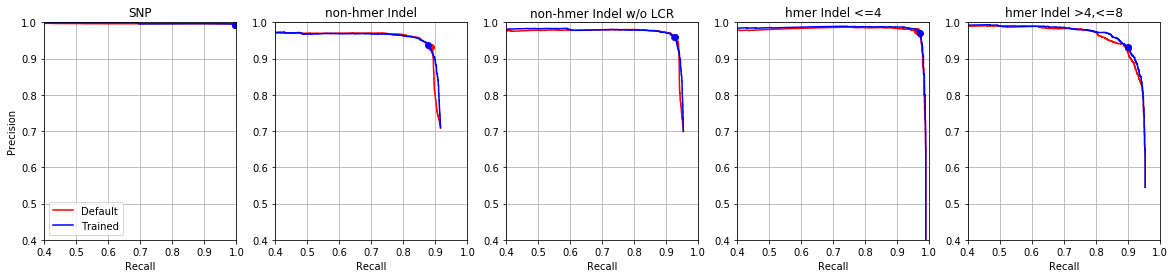

In [11]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary')


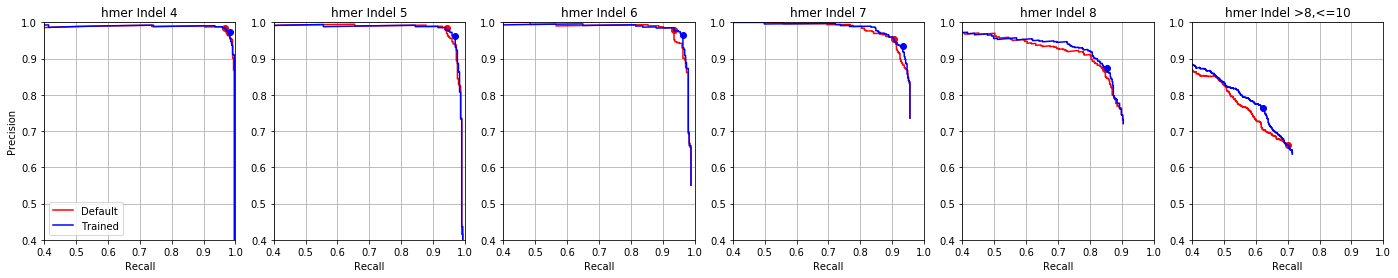

In [12]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers')


In [13]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     125162   1572     99.64% 99.49%    99.32% 99.41%   
non-hmer Indel            7117   2686     91.63% 88.70%    93.22% 90.91%   
non-hmer Indel w/o LCR    5349   2199     95.34% 92.47%    96.04% 94.22%   
hmer Indel <=4            2003  20621     99.10% 96.06%    97.62% 96.83%   
hmer Indel >4,<=8         1615   1287     95.36% 89.85%    92.95% 91.37%   
hmer Indel 4               343   1280     99.71% 96.79%    98.52% 97.65%   
hmer Indel 5               295    662     99.32% 94.24%    98.58% 96.36%   
hmer Indel 6               357    289     98.88% 93.56%    97.95% 95.70%   
hmer Indel 7               449    155     95.55% 90.65%    95.54% 93.03%   
hmer Indel 8               514    181     90.47% 84.63%    87.00% 85.80%   
hmer Indel >8,<=10        1332    544     71.47% 70.05%    66.26% 68.10%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     125162   1545     99.64% 99.44%    99.37% 99.40%  
non-hmer Indel            7117   2672     91.63% 87.79%    93.83% 90.71%  
non-hmer Indel w/o LCR    5349   2190     95.34% 92.73%    95.86% 94.27%  
hmer Indel <=4            2003  20621     99.10% 97.25%    96.96% 97.11%  
hmer Indel >4,<=8         1615   1287     95.36% 89.91%    93.14% 91.49%  
hmer Indel 4               343   1280     99.71% 98.25%    97.40% 97.82%  
hmer Indel 5               295    662     99.32% 96.95%    96.30% 96.62%  
hmer Indel 6               357    289     98.88% 96.36%    96.63% 96.49%  
hmer Indel 7               449    155     95.55% 93.32%    93.53% 93.42%  
hmer Indel 8               514    181     90.47% 85.41%    87.45% 86.42%  
hmer Indel >8,<=10        1332    544     71.47% 62.24%    76.48% 68.63%

### Including genotype

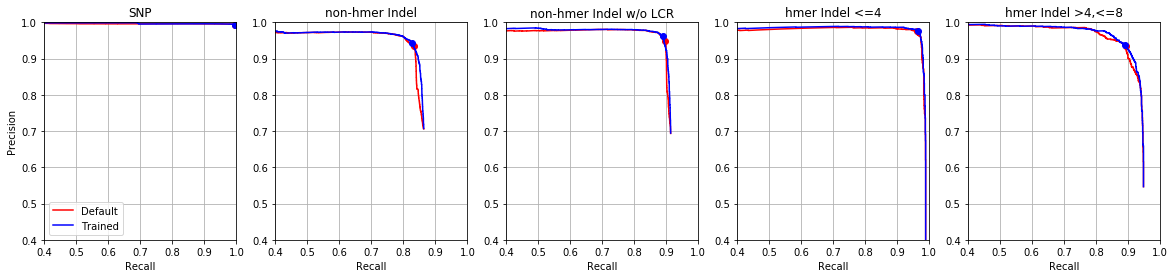

In [14]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories)

In [15]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df

Default                                            \
                         # pos  # neg max recall recall precision     F1   
SNP                     125091   1643     99.59% 99.45%    99.27% 99.36%   
non-hmer Indel            7210   2593     86.38% 83.27%    93.55% 88.11%   
non-hmer Indel w/o LCR    5376   2172     91.39% 89.60%    94.93% 92.19%   
hmer Indel <=4            2002  20622     99.05% 96.10%    97.57% 96.83%   
hmer Indel >4,<=8         1624   1278     94.83% 89.22%    93.48% 91.30%   

                       Trained                                            
                         # pos  # neg max recall recall precision     F1  
SNP                     125088   1619     99.59% 99.42%    99.31% 99.37%  
non-hmer Indel            7208   2581     86.39% 82.74%    94.32% 88.15%  
non-hmer Indel w/o LCR    5376   2163     91.39% 88.88%    96.12% 92.36%  
hmer Indel <=4            2002  20622     99.05% 96.60%    97.53% 97.06%  
hmer Indel >4,<=8         1624   1278     94.83% 89.04%    93.77% 91.35%

### homozygous calls

In [34]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df

Default                                           \
                         # pos # neg max recall recall precision     F1   
SNP                      54033     0     99.89% 99.89%   100.00% 99.95%   
non-hmer Indel            2635     0     85.35% 85.35%   100.00% 92.10%   
non-hmer Indel w/o LCR    2155     0     90.02% 90.02%   100.00% 94.75%   
hmer Indel <=4             837     0     99.76% 99.76%   100.00% 99.88%   
hmer Indel >4,<=8          667     0     98.50% 98.50%   100.00% 99.24%   

                       Trained                                           
                         # pos # neg max recall recall precision     F1  
SNP                      54032     0     99.89% 99.89%   100.00% 99.95%  
non-hmer Indel            2635     0     85.35% 85.35%   100.00% 92.10%  
non-hmer Indel w/o LCR    2155     0     90.02% 90.02%   100.00% 94.75%  
hmer Indel <=4             837     0     99.76% 99.76%   100.00% 99.88%  
hmer Indel >4,<=8          667     0     98.50% 98.50%   100.00% 99.24%

### per base

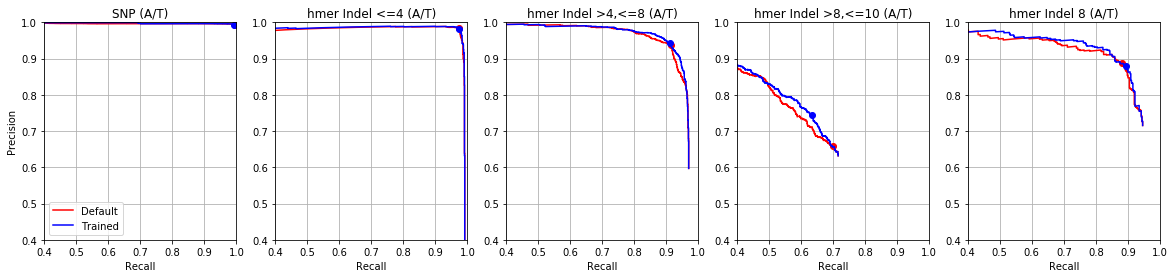

In [17]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'A/T')


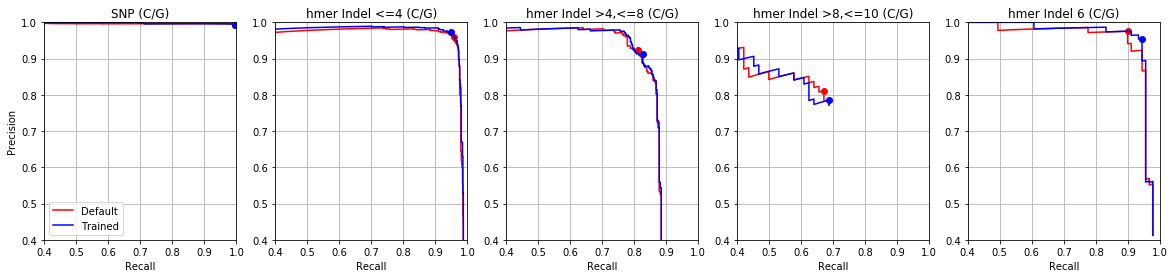

In [18]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,'C/G')


In [19]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="per_base_data")
df

Default                                            \
                           # pos  # neg max recall recall precision     F1   
SNP (A/T)                  59817    810     99.58% 99.41%    99.31% 99.36%   
hmer Indel <=4 (A/T)        1214   2163     99.18% 97.28%    98.33% 97.81%   
hmer Indel >4,<=8 (A/T)     1303    854     97.01% 91.56%    93.64% 92.59%   
hmer Indel >8,<=10 (A/T)    1268    530     71.61% 69.87%    65.82% 67.79%   
hmer Indel 8 (A/T)           460    174     94.57% 88.26%    88.84% 88.55%   
SNP (C/G)                  65344    757     99.69% 99.56%    99.36% 99.46%   
hmer Indel <=4 (C/G)         789  18458     98.99% 95.69%    95.93% 95.81%   
hmer Indel >4,<=8 (C/G)      312    433     88.46% 81.09%    92.34% 86.35%   
hmer Indel >8,<=10 (C/G)      64     14     68.75% 67.19%    81.13% 73.50%   
hmer Indel 6 (C/G)            89    125     97.75% 89.89%    97.56% 93.57%   

                         Trained                                            
                           # pos  # neg max recall recall precision     F1  
SNP (A/T)                  59817    794     99.59% 99.37%    99.34% 99.35%  
hmer Indel <=4 (A/T)        1214   2163     99.18% 97.53%    98.26% 97.89%  
hmer Indel >4,<=8 (A/T)     1303    854     97.01% 91.10%    94.28% 92.66%  
hmer Indel >8,<=10 (A/T)    1268    530     71.61% 63.49%    74.40% 68.51%  
hmer Indel 8 (A/T)           460    174     94.57% 89.35%    88.01% 88.67%  
SNP (C/G)                  65344    746     99.69% 99.54%    99.37% 99.46%  
hmer Indel <=4 (C/G)         789  18458     98.99% 94.93%    97.40% 96.15%  
hmer Indel >4,<=8 (C/G)      312    433     88.46% 82.69%    91.17% 86.72%  
hmer Indel >8,<=10 (C/G)      64     14     68.75% 68.75%    78.57% 73.33%  
hmer Indel 6 (C/G)            89    125     97.75% 94.38%    95.45% 94.92%

In [20]:
%matplotlib agg
d=defTable['Trained'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)

In [28]:
data['Default']

,chrom,pos,qual,ref,alleles,gt_ultima,gt_ground_truth,indel,classify,classify_gt,...,right_motif,gc_content,coverage,well_mapped_coverage,repetitive_read_coverage,close_to_hmer_run,inside_hmer_run,LCR-hs38,mappability.0,cycleskip_status
"(chr9, 203822)",chr9,203822,"75,106.00%",T,"(T, G)","(1, 1)","(1, 1)",False,tp,tp,...,CTGGA,60.00%,25,25,0,False,False,False,True,possible-cycle-skip
"(chr9, 203857)",chr9,203857,"93,106.00%",G,"(G, A)","(1, 1)","(1, 1)",False,tp,tp,...,CCTCT,60.00%,31,31,0,False,False,False,True,cycle-skip
"(chr9, 203898)",chr9,203898,"53,003.00%",T,"(T, TC)","(1, 1)","(1, 1)",True,tp,tp,...,AAGTA,60.00%,23,22,1,False,False,False,True,NA
"(chr9, 204014)",chr9,204014,"97,606.00%",A,"(A, G)","(1, 1)","(1, 1)",False,tp,tp,...,GGGTC,70.00%,29,29,0,False,False,False,True,cycle-skip
"(chr9, 204030)",chr9,204030,"58,205.00%",C,"(C, G)","(1, 1)","(1, 1)",False,tp,tp,...,CCCCC,80.00%,28,28,0,False,False,False,True,non-skip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr9, 138122900)",chr9,138122900,"133,606.01%",C,"(C, T)","(1, 1)","(1, 1)",False,tp,tp,...,TGTGA,50.00%,40,40,0,False,False,False,True,cycle-skip
"(chr9, 138123517)",chr9,138123517,"93,106.00%",C,"(C, T)","(1, 1)","(1, 1)",False,tp,tp,...,TTGGC,50.00%,28,28,0,False,False,False,True,cycle-skip
"(chr9, 138123560)",chr9,138123560,"31,802.00%",ATG,"(ATG, A)","(1, 1)","(1, 1)",True,tp,tp,...,TGTGT,40.00%,42,40,2,False,False,True,True,NA
"(chr9, 138124725)",chr9,138124725,"123,103.00%",T,"(T, TTTG)","(1, 1)","(1, 1)",True,tp,tp,...,TTGTT,20.00%,44,44,0,False,False,True,True,NA
